## Control Chart Application

In [65]:
import sys 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Building

In [56]:
def mw_st_std(xi, xr):
    xi = np.asarray(xi, dtype=float)
    xr = np.asarray(xr, dtype=float)

    n = xi.size
    m = xr.size
    N = n + m

    # Broadcasting: compare every xr against every xi
    # shapes: (m, n)
    less = (xr[:, None] < xi[None, :]).sum(axis=0)
    equal = (xr[:, None] == xi[None, :]).sum(axis=0)

    mw = less + equal / 2.0
    t = mw.sum()

    mt = (m * n) / 2.0
    sdt = np.sqrt((m * n * (N + 1)) / 12.0)

    return float((t - mt) / sdt)


## Application

In [57]:
# =========================
# Reproducibility
# =========================
np.random.seed(12)  # set.seed(30)

# Parameters
m = 500
n = 5
nic = 100
noc = 50

# Read data (same as read.csv(..., sep=";"))
D = pd.read_csv("winequality_white.csv", sep=";")

# =========================
# In-control (quality == 7)
# =========================
# D.ic = D[which(D[,ncol(D)] == 7),(1:(ncol(D)-1))]
target_col = D.columns[-1]
feature_cols = D.columns[:-1]

D_ic = D.loc[D[target_col] == 7, feature_cols].copy()

# r.ic = sample(1:nrow(D.ic), (m+nic))
# NOTE: R is 1-indexed, Python is 0-indexed.
r_ic = np.random.choice(D_ic.index.to_numpy(), size=(m + nic), replace=False)

# xr = D.ic[r.ic[1:m], ]
xr = D_ic.loc[r_ic[:m]].to_numpy()

# xic = D.ic[r.ic[(m+1):(m+nic)], ]
xic = D_ic.loc[r_ic[m:m + nic]].to_numpy()

# xoc = D[which(D[,ncol(D)] == 5),(1:(ncol(D)-1))]
xoc = D.loc[D[target_col] == 5, feature_cols].copy()

# xoc = xoc[sample(1:nrow(xoc), noc),]
xoc = xoc.sample(n=noc, random_state=30).to_numpy()  # keep seed effect stable

# xi = rbind(xic, xoc)
xi = np.vstack([xic, xoc])

# ni = nic + noc
ni = nic + noc

# m = nrow(xr); p = ncol(xr)
m = xr.shape[0]
p = xr.shape[1]

## Assumptions

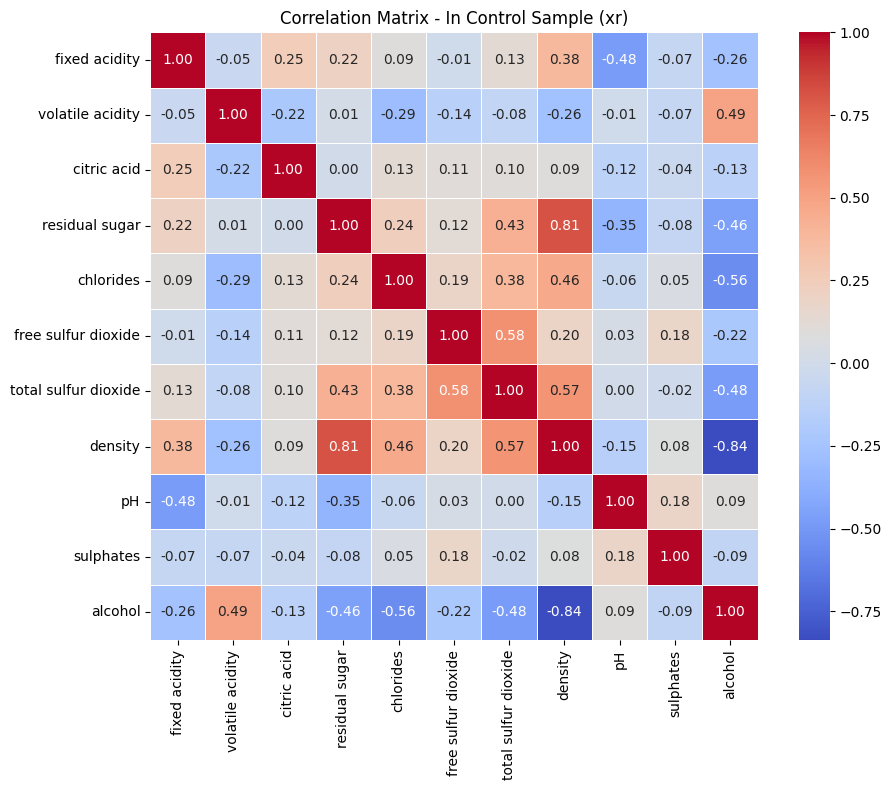

In [63]:
xr = pd.DataFrame(xr, columns=feature_cols)

# Matriz de correlación
corr_matrix = xr.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f",
            square=True, linewidths=0.5)

plt.title("Correlation Matrix - In Control Sample (xr)")
plt.tight_layout()
plt.show()

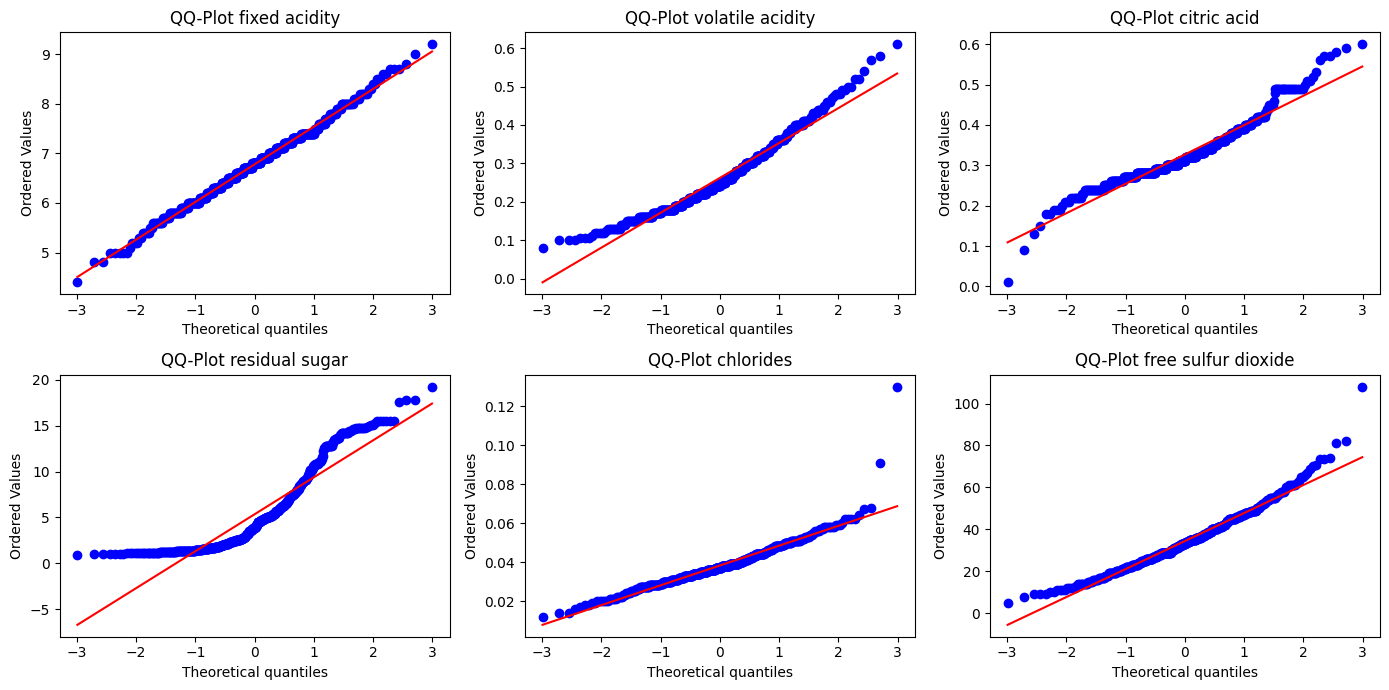

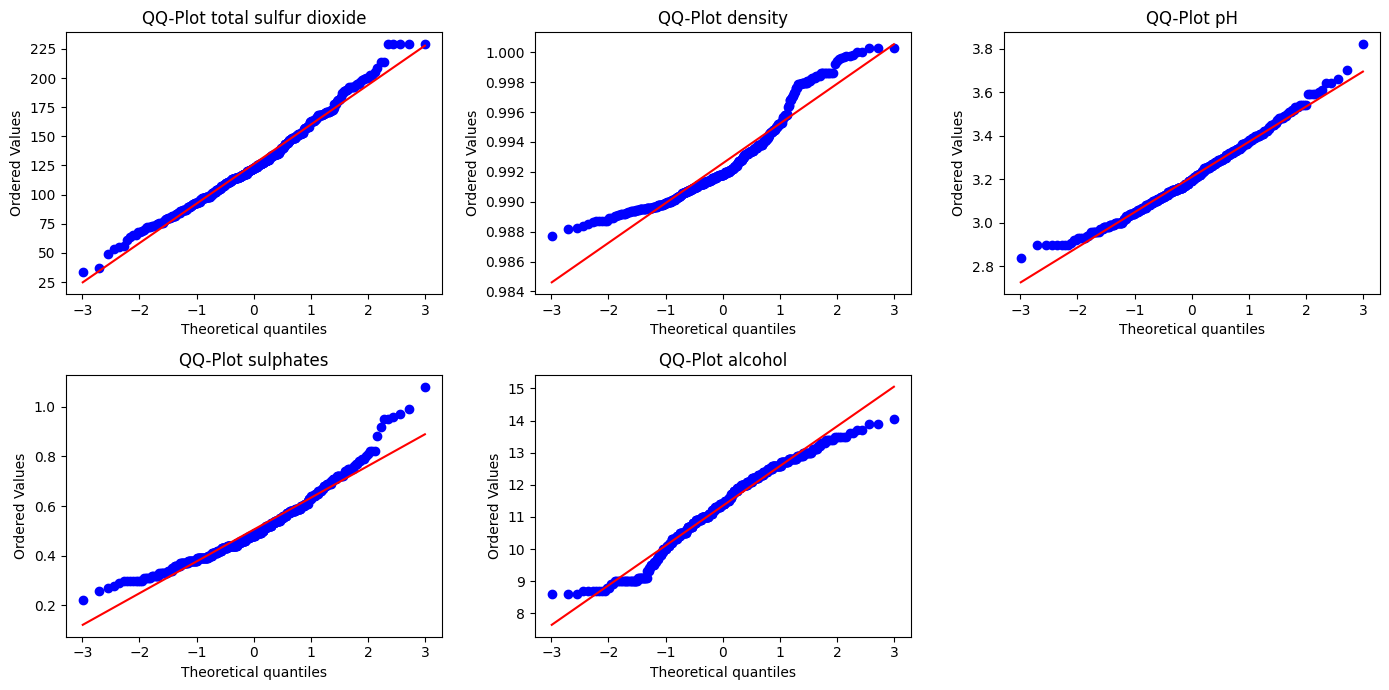

In [64]:
def qqplots_dataframe(df, cols_per_fig=6):
    import scipy.stats as stats
    import matplotlib.pyplot as plt
    import numpy as np

    cols = df.columns
    total = len(cols)

    for start in range(0, total, cols_per_fig):
        end = min(start + cols_per_fig, total)
        subset = cols[start:end]

        rows = 2
        cols_plot = 3

        fig, axes = plt.subplots(rows, cols_plot, figsize=(14, 7))
        axes = axes.ravel()

        for i, col in enumerate(subset):
            stats.probplot(df[col], dist="norm", plot=axes[i])
            axes[i].set_title(f"QQ-Plot {col}")

        for j in range(i + 1, rows * cols_plot):
            axes[j].axis("off")

        plt.tight_layout()
        plt.show()

qqplots_dataframe(xr)


## Implementation

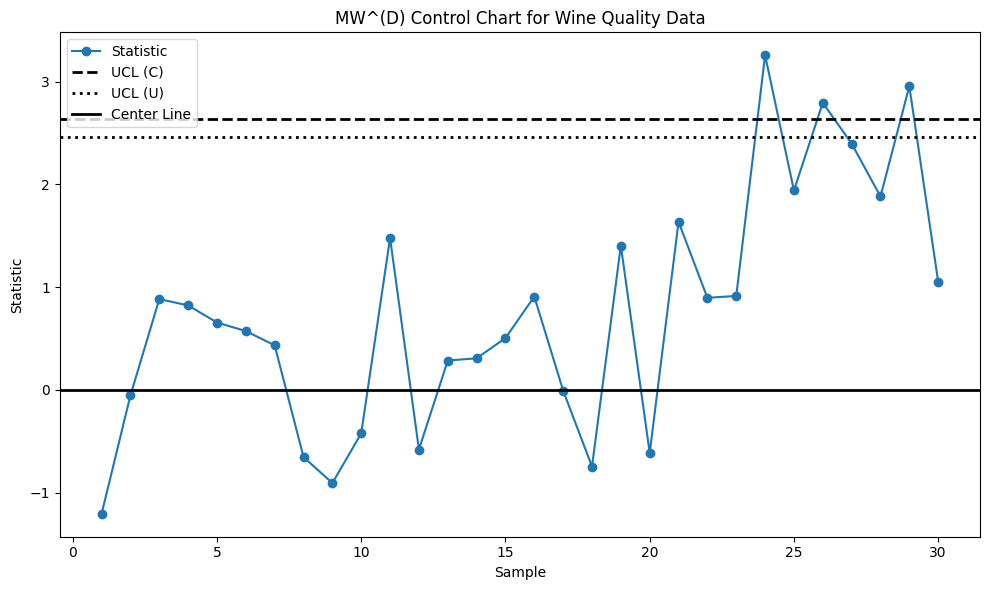

In [ ]:
# ni = nrow(xi)/n
# En R: ni = nrow(xi)/n y luego for (i in 1:ni) ...
# Aquí aseguramos entero:
ni_batches = xi.shape[0] // n
assert xi.shape[0] % n == 0, "xi rows must be divisible by n"

# =========================
# Compute reference T^2 for each row in xr with leave-one-out
# =========================
t2r = []

# for (j in 1:nrow(xr)) { s.xr <- xr[-j,] ... }
for j in range(m):
    s_xr = np.delete(xr, j, axis=0)          # xr[-j,] (leave-one-out)
    sm_r = s_xr.mean(axis=0)                 # apply(..., mean)
    sc_r = np.cov(s_xr, rowvar=False)        # cov

    diff = xr[j, :] - sm_r
    # R used solve(sc.r, tol=...), in Python we use inv or pinv.
    # pinv is closer to "tolerant inverse".
    sc_inv = np.linalg.pinv(sc_r)
    t2_val = float(diff.T @ sc_inv @ diff)
    t2r.append(t2_val)

    # print(j + 1)  # mimic R printing 1..m

t2r = np.array(t2r)

# =========================
# Process incoming samples in batches of size n
# =========================
m_st = []

for i in range(ni_batches):
    # xi_t2 = xi[(((i*n)+1)-n):(i*n), ] in R with i starting at 1
    # In Python with i starting 0: rows i*n ... i*n+n-1
    xi_t2 = xi[i*n:(i+1)*n, :]

    t2 = []
    for j in range(n):
        diff = xi_t2[j, :] - sm_r
        t2_val = float(diff.T @ sc_inv @ diff)
        t2.append(t2_val)

    t2 = np.array(t2)

    st = mw_st_std(t2, t2r)
    m_st.append(st)

    # print(i + 1)

m_st = np.array(m_st)
sec = np.arange(1, len(m_st) + 1)

# =========================
# Plot (matplotlib)
# =========================
plt.figure(figsize=(10, 6))

plt.plot(sec, m_st, marker="o", linestyle="-")

# abline(h=...)
plt.axhline(2.63442, linestyle="--", linewidth=2, color="black")   # UCL (C)
plt.axhline(2.463875, linestyle=":", linewidth=2, color="black")   # UCL (U)
plt.axhline(0, linestyle="-", linewidth=2, color="black")          # Center line

plt.title("MW^(D) Control Chart for Wine Quality Data")
plt.xlabel("Sample")
plt.ylabel("Statistic")

# legend(-0.5, 4, ...) no aplica igual; matplotlib maneja distinto.
plt.legend(["Statistic", "UCL (C)", "UCL (U)", "Center Line"], loc="upper left")

plt.tight_layout()
plt.show()